# Preprocessing

- Preprocess
- load data
- visual inspection, bad channels
- high pass and low pass filter
- remove eyeblinks with ICA
- epoching (+ baseline correct --> baseline = (None, 0)
        tmin = 0.5, tmax = 1.5) defined within epoch()
- trigger values (from AH's slide)
- reject from values


In [3]:
%matplotlib qt

In [4]:
import mne
import pandas as pd
import numpy as np
import os

## Loading data

In [5]:
#set the path to the data
raw = mne.io.read_raw_fif('/Users/thearolskovsloth/Documents/MASTERS_I_COGSCI/Advanced Cognitive Neuroscience/eeg_data/p1-raw.fif')                        
#load in the raw data
raw.load_data()

Opening raw data file /Users/thearolskovsloth/Documents/MASTERS_I_COGSCI/Advanced Cognitive Neuroscience/eeg_data/p1-raw.fif...
    Range : 0 ... 1214579 =      0.000 ...  1214.579 secs
Ready.
Reading 0 ... 1214579  =      0.000 ...  1214.579 secs...


<Raw | p1-raw.fif, 32 x 1214580 (1214.6 s), ~296.6 MB, data loaded>

In [6]:
#inspecting the data
raw.info

<Info | 12 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F7, F3, Fz, F4, F8, FC5, FC1, FC2, FC6, T7, C3, Cz, ...
 chs: 32 EEG
 custom_ref_applied: False
 description: Anonymized using a time shift to preserve age at acquisition
 dig: 35 items (3 Cardinal, 32 EEG)
 experimenter: mne_anonymize
 file_id: 4 items (dict)
 highpass: 0.0 Hz
 lowpass: 1000.0 Hz
 meas_date: 2000-01-01 00:00:00 UTC
 meas_id: 4 items (dict)
 nchan: 32
 projs: []
 sfreq: 1000.0 Hz
>

## Visual inspection

In [7]:
raw.plot(duration=4, n_channels=32);

Using matplotlib as 2D backend.


qt.qpa.drawing: Layer-backing can not be explicitly controlled on 10.14 when built against the 10.14 SDK


Channel C3 appears unstable. This is excluded, when inspecting the channels in the file browser.
Additionally, P09 is excluded due to 12% of the epoch being rejectiong which is discovered in the epoching process.

In [8]:
raw.info
raw.info['bads'] = ['C3', 'PO9']

## Filtering
Defining low pass filter as 40 Hz to let all frequencies lower than 40 Hz pass through and e.g. remove mucle artefacts and noise from power cords at 50 Hz.
Defing low pass filter as 0.1 to let all frequencies higher than 0.1 pass through and remove channel drifts.

In [9]:
low_pass = 40
high_pass = 0.1

#first applying the high pass - then low pass
raw.filter(l_freq = high_pass, h_freq = None) #high freq filter is a low pass filter
raw.filter(l_freq = None, h_freq = low_pass) #low freq filter is a high pass filter

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Filter length: 33001 samples (33.001 sec)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 sec)



<Raw | p1-raw.fif, 32 x 1214580 (1214.6 s), ~296.6 MB, data loaded>

## Artefact rejection

### ICA & components
ICA is splitting the totalt signal from all channels into different components (trial and tweeking to find the tight amount). This means that all eye-blink signals should be gathered in one component so we can throw it out. If there are two components with eyeblinks we should set less components and collapse them instead of throwing both away and risking loosing brain signal.

In [10]:
# set up and fit the ICA
#n_components is set to 0.95 which means it is set to pick the number of components that altogether will explain 95% of the variance
ica = mne.preprocessing.ICA(n_components=0.95, random_state=97, max_iter=800)
ica.fit(raw)

Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by explained variance: 11 components
Fitting ICA took 11.1s.


Method,fastica
Fit,15 iterations on raw data (1214580 samples)
ICA components,11
Explained variance,95.4 %
Available PCA components,30
Channel types,eeg
ICA components marked for exclusion,—


In [23]:
#visually investigate the components
ica.plot_components();

Component 1 appears to be a saccade and will therefore be removed.
Component 2 appears to be an eyeblink and will therefore be removed.
Component 0 was also investigated: These appears as loose electrodes. However, as it only occurs in a limited number of trials towards the end, the component is kept and partially corrected for during rejection from values. 

In [22]:
ica.exclude = [1,2]
#plotting the properties of the components to examine how many trials they affected.
ica.plot_properties(raw, picks=ica.exclude);
ica.plot_properties(raw, picks=0);

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
Not setting metadata
607 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
607 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
Not setting metadata
607 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


Creating RawArray with float64 data, n_channels=11, n_times=1214580
    Range : 0 ... 1214579 =      0.000 ...  1214.579 secs
Ready.


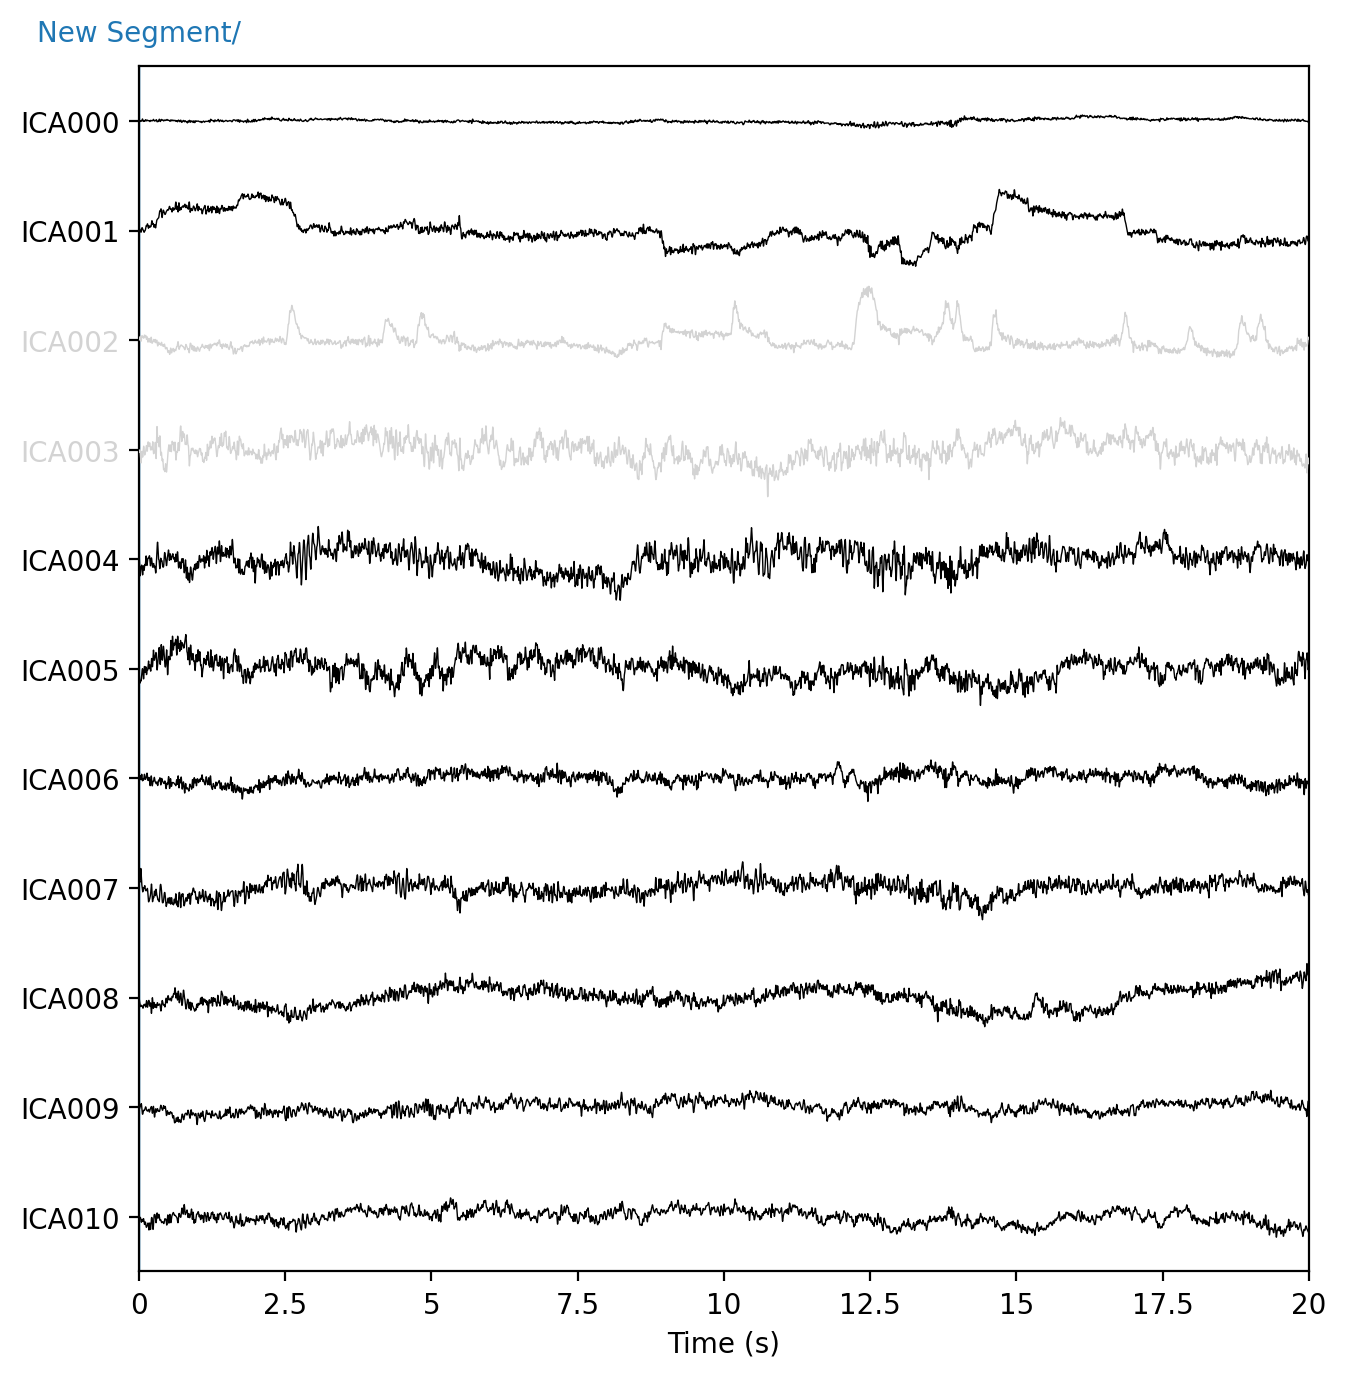

In [13]:
#Plotting the time series of the ICA.
ica.plot_sources(raw, show_scrollbars=False)

In [14]:
#apply the ICA to the raw data
ica.apply(raw)

Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 2 ICA components
    Projecting back using 30 PCA components


<Raw | p1-raw.fif, 32 x 1214580 (1214.6 s), ~296.6 MB, data loaded>

## Event detection

In [24]:
from trigger_function import convert_triggers

In [25]:
events, _ = mne.events_from_annotations(raw)

Non-RawBrainVision raw using branvision markers
Used Annotations descriptions: ['New Segment/', 'Stimulus/S  1', 'Stimulus/S 10', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 20']


Recode events to categorize failed or succesfull inhibition. The new codes are as follows: 
* "stop_signal": 11
* "go": 10
* "response": 1
* "stop_signal_only": 12
* "failed_response": 2 # the buttonpress at a failed inhibition
* "failed_inhibition": 37
* "successful_inhibition": 35

In [42]:
events, event_id = convert_triggers(events, return_event_ids=True)
events[0:10]

array([[     0,      0,  99999],
       [ 60957,      0,     10],
       [142467,      0,      1],
       [144481,      0,     35],
       [144681,      0,     11],
       [146351,      0,     10],
       [146654,      0,      1],
       [147931,      0,     10],
       [148158,      0,      1],
       [150091,      0,     30]])

In [43]:
event_id

{'stop_signal': 11,
 'go': 10,
 'response': 1,
 'stop_signal_only': 12,
 'failed_response': 2,
 'failed_inhibition': 37,
 'successful_inhibition': 35}

In [44]:
# defining a threshold to double check if we removed all eye blinks, etc.
reject_criteria = dict(eeg=150e-6)  # 150 µV

In [45]:
mne.viz.plot_events(events[:50], sfreq=250, first_samp=raw.first_samp, event_id=event_id);

/var/folders/lr/m88n3jxd3ls79c_st34bhpr00000gn/T/ipykernel_6344/329882116.py:1: RuntimeWarning: event 30 missing from event_id will be ignored
  mne.viz.plot_events(events[:50], sfreq=250, first_samp=raw.first_samp, event_id=event_id);
/var/folders/lr/m88n3jxd3ls79c_st34bhpr00000gn/T/ipykernel_6344/329882116.py:1: RuntimeWarning: event 99999 missing from event_id will be ignored
  mne.viz.plot_events(events[:50], sfreq=250, first_samp=raw.first_samp, event_id=event_id);


## Epoching

In [46]:
# defining the temporal epoch
tmin, tmax = -0.2, 0.7

In [47]:
#defining baseline as the time from onset to baseline correction --> en tuple der indeholder intervallet; FRA første sample TIL første event (tid 0)
baseline = (None, 0) 

# defining epochs
epochs = mne.Epochs(raw,
                    events,
                    event_id=event_id,
                    tmin=tmin,
                    tmax=tmax,
                    baseline = baseline,
                    reject=reject_criteria,
                    preload=True)

Not setting metadata
Not setting metadata
772 matching events found
Setting baseline interval to [-0.5, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 772 events and 2001 original time points ...
    Rejecting  epoch based on EEG : ['PO10']
    Rejecting  epoch based on EEG : ['F7', 'F8']
    Rejecting  epoch based on EEG : ['F7', 'F8']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['F7', 'F8']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['P4']
    Rejecting  epoch based on EEG : ['P4']
    Rejecting  epoch based on EEG : ['TP10']
 

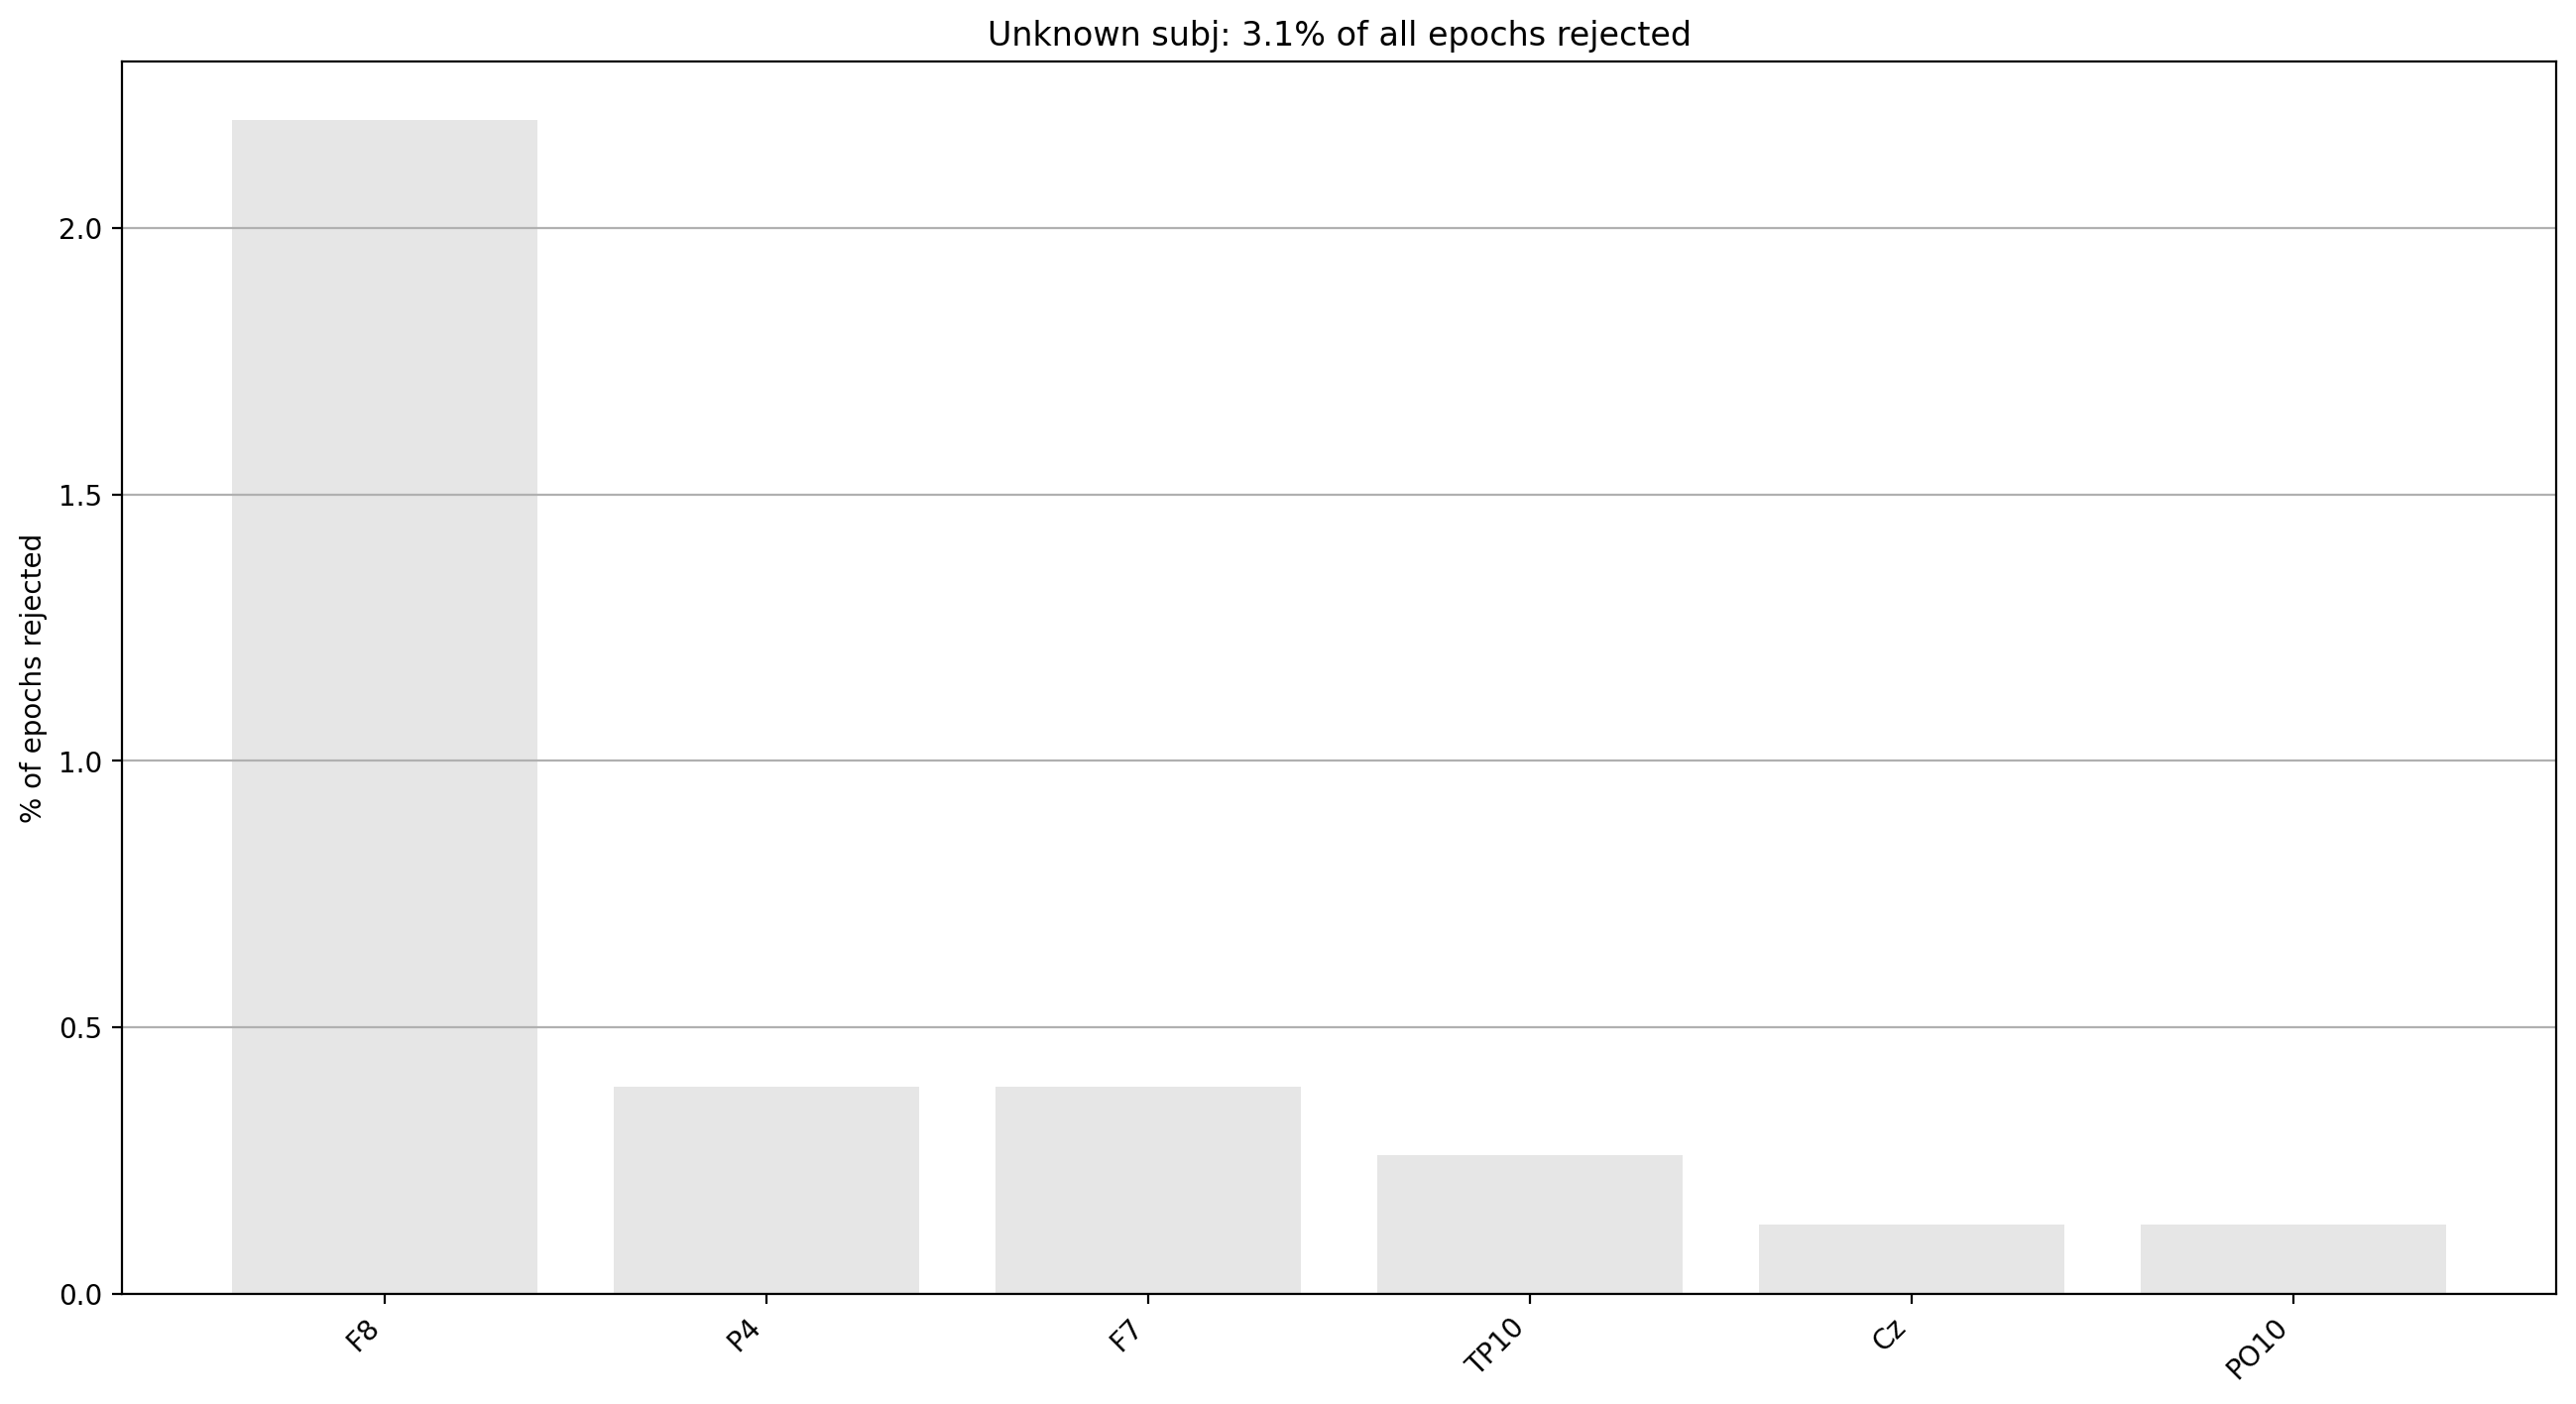

In [48]:
#inspecting the rejected epochs
epochs.plot_drop_log()

*Note*: Channel P09 appears to be the source of noise as it leads to more than 12% of the epochs being rejected. Thus, we exclude it from the data and rerun the ICA.

# Creating and comparing ERPs
In the analysis we are interested in comparing the epochs containing successful inhibition and failed inhibition. In the following section we select these conditions, equalize the number of trials in each, average over them (constructing ERPs), and compare them visually.

In [49]:
#specify the conditions that are relevant for the analysis
conds_we_care_about = ['successful_inhibition', 'failed_inhibition']

In [50]:
epochs.equalize_event_counts(conds_we_care_about)  # equalize number of trails in each condition
succ_epochs = epochs['successful_inhibition']
fail_epochs = epochs['failed_inhibition']

Dropped 9 epochs: 54, 116, 128, 134, 172, 178, 182, 376, 382


In [51]:
succ_evoked = succ_epochs.average()
fail_evoked = fail_epochs.average()

In [52]:
succ_evoked.plot(gfp=True);
#gfp: global field power, signal to noise ratio. this will change when 

In [53]:
fail_evoked.plot(gfp=True);

In [55]:
fail_evoked.plot_joint();

No projector specified for this dataset. Please consider the method self.add_proj.


In [54]:
succ_evoked.plot_joint();

No projector specified for this dataset. Please consider the method self.add_proj.


In [56]:
difference_wave = mne.combine_evoked([succ_evoked, fail_evoked], weights=[1, -1])

In [58]:
mne.viz.plot_compare_evokeds(dict(success = succ_evoked, fail = fail_evoked, difference = difference_wave), legend = 'upper right')

combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"


[<Figure size 1280x600 with 1 Axes>]

In [59]:
difference_wave.plot_topomap();

/Users/thearolskovsloth/opt/anaconda3/envs/mne/lib/python3.9/site-packages/mne/viz/_mpl_figure.py:2049: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure(FigureClass=FigureClass, **kwargs)


plotting gfp

make topographies for every 100-ish ms (for both conds and difference wave)